<a href="https://colab.research.google.com/github/mtfaye/zesty/blob/master/Zesty_ai_takehome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RECS - Predict Electricity Consumption 

The goal of this notebook is to build a model that predicts the electricity consumption of a given household using the RECS survey data. 


## Dependencies

In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd
from scipy import stats

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning libraries
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

# neural net
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import warnings
warnings.filterwarnings('ignore')  # use at the end 

1.15.0


## Loading The Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# directory root
path_raw_data = '/content/drive/My Drive/zesty.ai/recs2009_public.csv'

In [0]:
# load raw data
raw_df = pd.read_csv(path_raw_data)

In [5]:
raw_df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,METROMICRO,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,...,BTUKEROTH,DOLLARKER,DOLKERSPH,DOLKERWTH,DOLKEROTH,BTUWOOD,CORDSWD,TOTALBTU,TOTALBTUSPH,TOTALBTUCOL,TOTALBTUWTH,TOTALBTURFG,TOTALBTUOTH,TOTALDOL,TOTALDOLSPH,TOTALDOLCOL,TOTALDOLWTH,TOTALDOLRFG,TOTALDOLOTH,KAVALEL,PERIODEL,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,4,3,METRO,U,1,-2,2004,7,8,-2,-2,-2,-2,-2,1,5,-2,-2,20,-2,4,1,2,5,9,1,0,0,1,1,...,0.0,0,0.0,0,0.0,0,0.0,63006,10873,10471,10128,5171,26363,1315,227,219,211,108,550,1,1,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,5,4,METRO,U,2,-2,1998,6,8,-2,-2,-2,-2,-2,2,2,-2,-2,31,-2,3,2,1,1,4,0,0,0,-2,-2,...,0.0,0,0.0,0,0.0,20000,1.0,103460,38606,621,30110,4470,29653,1293,368,17,287,121,501,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,1,2,METRO,U,2,-2,1965,3,7,-2,-2,-2,2,8,1,-2,0,1,-2,-2,1,1,0,1,2,-2,-2,-2,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,58716,40248,629,7933,3124,6781,1327,582,49,115,243,339,1,1,0,3,5,3,-2,-2,-2,-2,-2,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,1,2,METRO,U,1,-2,1985,5,5,-2,-2,-2,-2,-2,6,5,-2,-2,10,-2,3,2,1,4,7,0,1,0,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,76401,40196,3627,6440,5700,20438,1398,425,101,179,159,534,3,5,3,3,5,3,-2,-2,-2,-2,-2,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,1,3,METRO,U,1,1,1983,5,5,-2,-2,-2,-2,-2,2,5,-2,-2,20,-2,2,1,1,3,5,1,0,0,0,-2,...,0.0,0,0.0,0,0.0,0,0.0,59809,36136,0,13884,1182,8607,1558,616,0,237,85,620,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,1,1,METRO,U,1,-2,1985,5,7,-2,-2,-2,-2,-2,3,6,-2,-2,10,-2,3,2,0,3,6,1,0,0,1,1,...,0.0,0,0.0,0,0.0,20000,1.0,75702,49610,333,6471,1933,17356,1541,521,13,253,76,678,1,1,0,3,5,3,-2,-2,-2,-2,-2,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,2,5,METRO,U,2,-2,1980,5,8,1,-2,-2,-2,-2,1,2,1,1,-2,-2,-2,1,0,1,1,0,0,1,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,25251,15148,1217,3645,1979,3262,543,273,51,54,83,82,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,1,1,METRO,U,1,-2,1993,6,7,-2,-2,-2,-2,-2,3,6,-2,-2,31,-2,4,3,1,4,8,0,0,0,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,148252,70626,2893,24391,7413,42930,2093,591,98,204,250,950,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,1,2,METRO,U,1,-2,1930,1,4,-2,-2,-2,-2,-2,1,6,-2,-2,10,-2,3,1,0,2,5,1,0,0,1,1,...,0.0,0,0.0,0,0.0,0,0.0,81978,49821,463,12416,6318,12960,1023,432,13,108,175,295,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


## EDA and Preprocessing 

In [6]:
# quick overview 
raw_df.describe()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,...,BTUKERWTH,BTUKEROTH,DOLLARKER,DOLKERSPH,DOLKERWTH,DOLKEROTH,BTUWOOD,CORDSWD,TOTALBTU,TOTALBTUSPH,TOTALBTUCOL,TOTALBTUWTH,TOTALBTURFG,TOTALBTUOTH,TOTALDOL,TOTALDOLSPH,TOTALDOLCOL,TOTALDOLWTH,TOTALDOLRFG,TOTALDOLOTH,KAVALEL,PERIODEL,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,1.208300e+04,12083.000000,12083.000000,12083.000000,12083.000000,12083.00000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,6042.000000,2.628321,5.373086,14.783663,2.659604,9402.981870,4141.375238,1415.406108,4135.146983,1443.503104,2.601010,3.265000,1.338078,-1.801457,1971.062402,4.027725,6.691964,-1.752793,-1.952164,-1.955640,-1.066705,4.486717,2.738889,3.676157,-1.510635,-1.269635,10.507738,-1.899694,2.773070,1.672101,0.307788,3.186626,5.995283,-0.081685,-0.188612,-0.028221,-1.183729,-1.330050,-1.171481,-1.418687,...,9.133080,22.976178,4.199040,3.588801,0.167508,0.442719,4507.572623,0.225379,8.999570e+04,36863.469006,5750.135811,16265.617314,4241.701564,26874.77547,2036.554415,559.180005,202.538856,280.615410,154.143921,840.080692,1.247041,1.511959,0.356368,0.131590,0.409832,-0.365720,-1.557643,-1.698668,-1.651246,-1.760821,-1.935943,-1.955392,1681.961764,139.568485,3763.728544,0.499036,5.656046,59.128693,20.256311,90.359431
std,3488.205986,1.042142,2.859366,8.195824,1.192627,5192.101419,2317.759375,1134.659475,2260.543686,1021.748722,1.349571,1.278652,0.497299,0.784550,24.817912,2.119578,1.535312,0.865886,0.364856,0.386862,2.766326,29.662574,1.512821,2.772088,0.890336,1.323690,8.779010,0.472066,1.217654,0.740713,0.507707,1.397913,2.178903,1.065492,0.999717,1.092986,1.207565,1.589095,1.224464,1.271622,...,622.197228,934.612760,55.807459,50.810579,11.411894,17.634764,20387.976747,1.019399,5.446876e+04,35583.121163,8458.828563,13552.792061,2656.406897,19867.08782,1174.803263,500.410826,309.989344,193.722371,106.281487,608.105246,0.647380,1.289145,0.963988,1.787474,2.277484,1.600439,1.524468,1.061814,1.332130,0.931025,0.589907,0.415810,1401.079218,264.186908,2597.754419,0.083520,6.797205,8.678293,15.337626,6.166669
min,1.000000,1.000000,1.000000,1.000000,1.000000,476.100000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-2.000000,1920.000000,1.000000,1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,1.000000,1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.800000e+01,0.000000,0.000000,0.000000,0.000000,33.00000,6.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.

Our raw data has 12083 rows and 940 columns. 
940 columns it is a lot. 
We should spend some time exploring it and try to understand what feature each column represents. This is important, because having a poor understanding of the features could cause us to make mistakes in the data analysis and the modeling process.

Let's take a look at the "Layout file" and "codebook file", which contains descriptive labels and formats for each data variable:

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(50), int64(885), object(5)
memory usage: 86.7+ MB


In [0]:
def resumetable(raw_df):
  # function that resumes better our dataframe

    print(f"Dataset Shape: {raw_df.shape}")
    summary = pd.DataFrame(raw_df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = raw_df.isnull().sum().values    
    summary['Uniques'] = raw_df.nunique().values
    summary['First Value'] = raw_df.loc[0].values
    summary['Second Value'] = raw_df.loc[1].values
    summary['Third Value'] = raw_df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(raw_df[name].value_counts(normalize=True), base=10),2) 

    return summary

In [9]:
resumetable(raw_df)

Dataset Shape: (12083, 940)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,DOEID,int64,0,12083,1,2,3,4.08
1,REGIONC,int64,0,4,2,4,1,0.59
2,DIVISION,int64,0,10,4,10,1,0.94
3,REPORTABLE_DOMAIN,int64,0,27,12,26,1,1.34
4,TYPEHUQ,int64,0,5,2,2,5,0.48
...,...,...,...,...,...,...,...,...
935,WSF,float64,0,50,0.48,0.61,0.48,1.51
936,OA_LAT,int64,0,35,6,0,3,1.18
937,GWT,int64,0,53,56,64,52,1.51
938,DesignDBT99,int64,0,90,9,38,12,1.78


In [10]:
# collect column names which have missing values
missing_data_cols = [col for col in raw_df.columns if raw_df[col].isnull().any()]
missing_data_cols

[]

Looks like there is no null values in our dataframe as it returned an empty list.

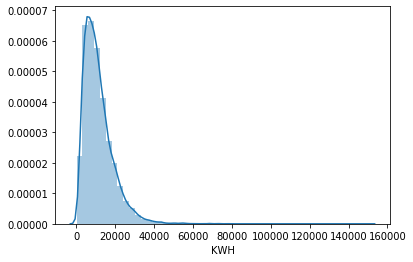

In [11]:
# target variable distribution
sns.distplot(raw_df.KWH)

In [12]:
raw_df.KWH.describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

In [13]:
print("Skewness: %f" % raw_df.KWH.skew())

Skewness: 2.114188


The target variable is positively skewed with a mean value 11288.15, we will have to apply transformation to convert it to near normal distribution.

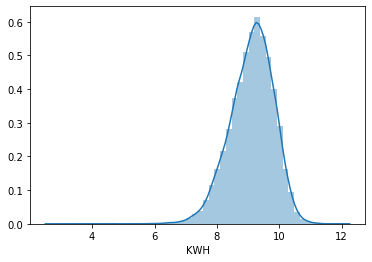

In [14]:
raw_df.KWH = np.log(raw_df.KWH )
sns.distplot(raw_df.KWH)

In [15]:
print("Skewness: %f" % raw_df.KWH.skew())

Skewness: -0.564432


The rule of thumb seems to be if the skewness is between -0.5 and 0.5, the data is fairly symmetrical. Therefore we are good to go now.

In [0]:
# features variables
features_cols = raw_df.loc[:, raw_df.columns != "KWH"]

In [17]:
# numerical columns for the independant variables
numerical_feature_columns = list(features_cols._get_numeric_data().columns)
print ("Number of numeric columns = {}".format(len(numerical_feature_columns)))

Number of numeric columns = 934


In [18]:
# categorical columns for the independant variables
categorical_feature_columns = list(set(features_cols.columns) - set(features_cols._get_numeric_data().columns))
print ("Number of categorical columns = {}".format(len(categorical_feature_columns)))
print(" ")
categorical_feature_columns

Number of categorical columns = 5
 


['NKRGALNC', 'IECC_Climate_Pub', 'NOCRCASH', 'UR', 'METROMICRO']

In [19]:
 raw_df[categorical_feature_columns].head()

,NKRGALNC,IECC_Climate_Pub,NOCRCASH,UR,METROMICRO
0,-2,4A,-2,U,METRO
1,-2,3C,-2,U,METRO
2,-2,5A,-2,U,METRO
3,-2,5A,-2,U,METRO
4,-2,5A,-2,U,METRO


In [20]:
raw_df[categorical_feature_columns].nunique()

NKRGALNC            21
IECC_Climate_Pub    11
NOCRCASH            29
UR                   2
METROMICRO           3
dtype: int64

Column UR and METROMICRO contain nominal variables with low cardinality so we can use one-hot encoding to convert from categorical to numeric.

In [0]:
raw_df = pd.get_dummies(raw_df, columns=["UR", "METROMICRO"], drop_first=True)

In [0]:
# drop the columns NOCRCASH, NKRGALNC and IECC_Climate_Pub
columns = ['NOCRCASH', 'NKRGALNC', 'IECC_Climate_Pub']
raw_df.drop(columns, inplace=True, axis=1)

In [0]:
# rename the finale dataframe
df = raw_df.copy()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 938 entries, DOEID to METROMICRO_NONE
dtypes: float64(51), int64(884), uint8(3)
memory usage: 86.2 MB


Now that our data looks tidy, let's select the right features for our prediction model.

## Features Selection

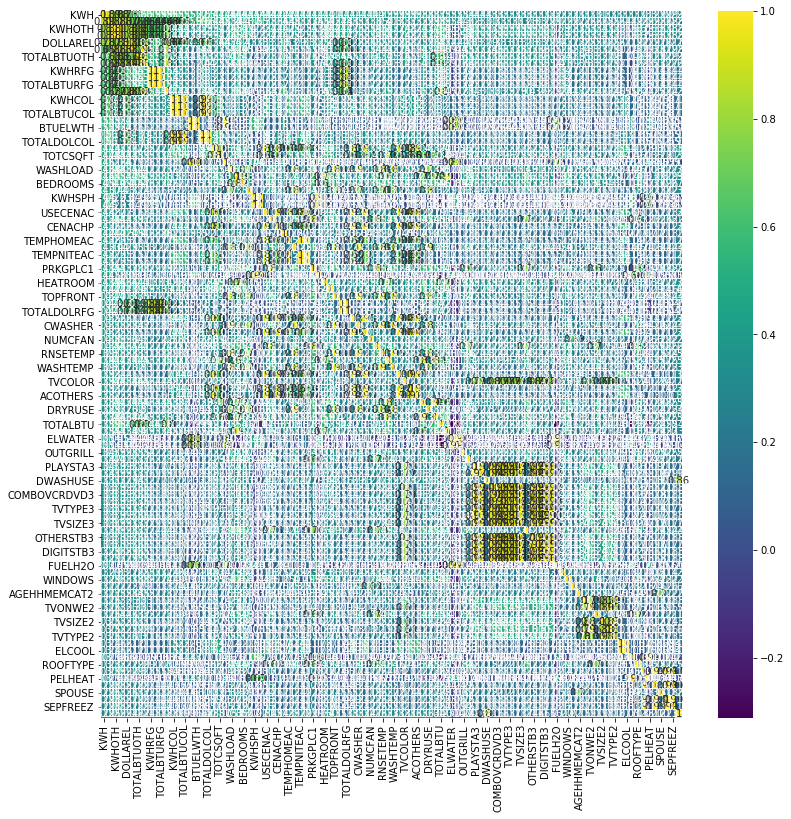

In [25]:
# return only the 100 highest correlation
k = 100
cols = df.corr().nlargest(k, 'KWH')['KWH'].index
cm = df[cols].corr()
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [26]:
cols

Index(['KWH', 'BTUEL', 'KWHOTH', 'BTUELOTH', 'DOLLAREL', 'DOLELOTH',
       'TOTALBTUOTH', 'TOTALDOLOTH', 'KWHRFG', 'BTUELRFG', 'TOTALBTURFG',
       'TOTALDOL', 'KWHCOL', 'BTUELCOL', 'TOTALBTUCOL', 'KWHWTH', 'BTUELWTH',
       'DOLELCOL', 'TOTALDOLCOL', 'ACROOMS', 'TOTCSQFT', 'DOLELWTH',
       'WASHLOAD', 'TOTROOMS', 'BEDROOMS', 'DRYRFUEL', 'KWHSPH', 'BTUELSPH',
       'USECENAC', 'WELLPUMP', 'CENACHP', 'TOTALDOLWTH', 'TEMPHOMEAC', 'DRYER',
       'TEMPNITEAC', 'TEMPGONEAC', 'PRKGPLC1', 'DOLELSPH', 'HEATROOM',
       'NCOMBATH', 'TOPFRONT', 'DOLELRFG', 'TOTALDOLRFG', 'MAINTAC', 'CWASHER',
       'THERMAINAC', 'NUMCFAN', 'SWIMPOOL', 'RNSETEMP', 'TOTHSQFT', 'WASHTEMP',
       'PELAC', 'TVCOLOR', 'PROTHERMAC', 'ACOTHERS', 'TOTSQFT', 'DRYRUSE',
       'TOTSQFT_EN', 'TOTALBTU', 'OTHROOMS', 'ELWATER', 'PELHOTWA', 'OUTGRILL',
       'NOUTLGTNT', 'PLAYSTA3', 'CABLESAT3', 'DWASHUSE', 'TVAUDIOSYS3',
       'COMBOVCRDVD3', 'TVONWE3', 'TVTYPE3', 'TVONWD3', 'TVSIZE3', 'STORIES',
       'OTHERSTB3

In [27]:
# create a dataframe with variables in cols
train_df = df[cols]
train_df 

,KWH,BTUEL,KWHOTH,BTUELOTH,DOLLAREL,DOLELOTH,TOTALBTUOTH,TOTALDOLOTH,KWHRFG,BTUELRFG,TOTALBTURFG,TOTALDOL,KWHCOL,BTUELCOL,TOTALBTUCOL,KWHWTH,BTUELWTH,DOLELCOL,TOTALDOLCOL,ACROOMS,TOTCSQFT,DOLELWTH,WASHLOAD,TOTROOMS,BEDROOMS,DRYRFUEL,KWHSPH,BTUELSPH,USECENAC,WELLPUMP,CENACHP,TOTALDOLWTH,TEMPHOMEAC,DRYER,TEMPNITEAC,TEMPGONEAC,PRKGPLC1,DOLELSPH,HEATROOM,NCOMBATH,...,ELWATER,PELHOTWA,OUTGRILL,NOUTLGTNT,PLAYSTA3,CABLESAT3,DWASHUSE,TVAUDIOSYS3,COMBOVCRDVD3,TVONWE3,TVTYPE3,TVONWD3,TVSIZE3,STORIES,OTHERSTB3,DVD3,DIGITSTB3,VCR3,FUELH2O,ICE,WINDOWS,USECFAN,AGEHHMEMCAT2,CABLESAT2,TVONWE2,ATTIC,TVSIZE2,TVONWD2,TVTYPE2,AIRCOND,ELCOOL,ELWARM,ROOFTYPE,SIZFREEZ,PELHEAT,NUMFREEZ,SPOUSE,FREEZER,SEPFREEZ,DISHWASH
0,9.823686,63006,7726.55,26362.97,1315,550.22,26363,550,1515.50,5170.90,5171,1315,3068.80,10470.73,10471,2968.45,10128.35,218.54,219,9,3958,211.39,2,9,4,5,3186.71,10873.05,3,0,0,211,74,1,73,78,1,226.93,9,1,...,1,1,1,0,0,0,13,0,0,2,3,3,3,20,0,1,0,0,5,1,41,3,8,1,2,0,3,2,4,1,1,1,5,-2,1,-2,1,-2,0,1
1,8.546364,17565,3655.78,12473.54,475,337.32,29653,501,1310.22,4470.48,4470,1293,182.00,620.98,621,0.00,0.00,16.79,17,4,2736,0.00,2,4,3,1,0.00,0.00,1,0,0,287,-2,1,-2,-2,1,0.00,4,2,...,0,-2,1,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,31,-2,-2,-2,-2,1,1,41,-2,4,1,2,0,2,2,2,1,1,0,2,-2,-2,-2,0,-2,0,0
2,7.704361,7568,1117.88,3814.29,588,296.35,6781,339,915.66,3124.32,3124,1327,184.46,629.39,629,0.00,0.00,48.90,49,-2,264,0.00,-2,2,1,-2,0.00,0.00,-2,-2,-2,115,-2,0,-2,-2,-2,0.00,2,1,...,0,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,0,20,2,-2,-2,-2,-2,-2,-2,-2,1,1,0,-2,-2,-2,-2,0,-2,0,0
3,9.211839,34171,5393.91,18403.93,952,512.73,20438,534,1670.53,5699.83,5700,1398,1063.02,3627.01,3627,1887.53,6440.22,101.05,101,7,1623,179.42,2,7,3,5,0.00,0.00,3,0,0,179,74,1,68,74,1,0.00,7,2,...,1,1,1,0,0,1,20,0,0,2,1,2,1,10,0,0,0,0,5,0,41,1,-2,1,3,0,1,3,1,1,1,0,5,-2,-2,-2,0,-2,0,1
4,7.961719,9789,2522.53,8606.86,705,619.86,8607,620,346.47,1182.14,1182,1558,0.00,0.00,0,0.00,0.00,0.00,0,-2,0,0.00,2,5,2,5,0.00,0.00,-2,0,-2,237,-2,1,-2,-2,0,0.00,5,1,...,0,-2,1,0,-2,-2,30,-2,-2,-2,-2,-2,-2,20,-2,-2,-2,-2,1,0,30,-2,-2,1,1,0,3,1,2,0,0,0,5,-2,-2,-2,0,-2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,8.942069,26092,5086.55,17355.61,1020,678.47,17356,678,566.54,1933.08,1933,1541,97.50,332.67,333,1896.41,6470.65,13.01,13,5,893,252.95,2,6,3,5,0.00,0.00,1,0,0,253,-2,1,-2,-2,1,0.00,5,2,...,1,1,1,0,-2,-2,20,-2,-2,-2,-2,-2,-2,10,-2,-2,-2,-2,5,0,30,1,-2,0,2,0,2,2,1,1,1,0,6,1,-2,1,0,1,1,1
12079,7.502738,6186,356.74,1217.20,260,51.16,3262,82,580.11,1979.33,1979,543,356.57,1216.63,1217,0.00,0.00,51.14,51,1,502,0.00,-2,1,-2,-2,519.59,1772.84,1,-2,0,54,-2,0,-2,-2,-2,74.51,1,1,...,0,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,0,30,-2,-2,-2,-2,0,-2,-2,-2,1,1,1,2,-2,1,-2,0,-2,0,0
12080,9.193601,33554,6813.65,23248.43,1133,785.02,42930,950,2172.62,7413.07,7413,2093,847.73,2892.50,2893,0.00,0.00,97.67,98,8,4181,0.00,3,8,4,1,0.00,0.00,1,0,0,204,-2,1,-2,-2,1,0.00,8,3,...,0,-2,1,0,0,1,20,0,0,1,2,1,1,31,0,0,0,0,1,1,42,1,8,1,1,0,2,2,2,1,1,0,6,-2,-2,-2,1,-2,0,1
12081,8.476371,16378,2812.67,9597.05,454,266.03,12960,295,1851.65,6317.98,6318,1023,135.69,462.98,463,0.00,0.00,12.83,13,3,518,0.00,2,5,3,1,0.00,0.00,1,0,0,108,-2,1,-2,-2,0,0.00,5,1,...,0,-2,0,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,10,-2,-2,-2,-2,1,0,41,2,-2,1,1,0,2,1,1,1,1,0,6,-2,-2,-2,0,-2,0,0


Removing Multicolinearity using VIF

In [0]:
#col_vif_dict = {}
#for cols in train_df.columns:
 #   y = train_df.KWH
 #   x = train_df.loc[:, train_df.columns != "KWH"]
  #  model = sm.OLS(y, x)
  #  results = model.fit()
  #  rsq = results.rsquared
  #  vif = round(1 / (1 - rsq), 2)
  #  col_vif_dict[cols] = vif

In [0]:
#col_vif_dict

A rule of thumb commonly used in practice is if a VIF is > 10, you have high multicollinearity.

In [0]:
#multicolinear_features = [key for key,value in col_vif_dict.items() if value > 10]
#multicolinear_features

In [0]:
# drop multicolinear features
#train_df.drop(multicolinear_features, inplace=True, axis=1)

In [0]:
TARGET = train_df.KWH

In [0]:
train_df["TARGET"] = TARGET

In [0]:
df_finale = train_df.copy()

## Modeling 

In [0]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) for coef, name in lst)

In [0]:
def load_data():
    data = df_finale
    X = data.loc[:, data.columns != "TARGET"]
    y = data.TARGET
    names = data.columns
    return X,y,names

In [0]:
def scale_data(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

In [0]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [0]:
def root_mean_square_error(y_pred,y_test):
    rmse_train = np.sqrt(np.dot(abs(y_pred-y_test),abs(y_pred-y_test))/len(y_test))
    return rmse_train

In [0]:
def plot_real_vs_predicted(y_pred,y_test):
    plt.plot(y_pred,y_test,'ro')
    plt.plot([0,10],[0,10], 'g-')
    plt.xlabel('predicted')
    plt.ylabel('real')
    plt.show()
    return plt

In [0]:
def generate_regression_values(model, X, y):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X)
    newX = pd.DataFrame({"Constant": np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y - predictions) ** 2)) / (len(newX) - len(newX.columns))

    var_b = MSE * (np.linalg.inv(np.dot(newX.T, newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

    sd_b = np.round(sd_b, 3)
    ts_b = np.round(ts_b, 3)
    p_values = np.round(p_values, 3)
    params = np.round(params, 4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3[
        "Probabilites"
    ] = [params, sd_b, ts_b, p_values]
    print(myDF3)

In [0]:
np.set_printoptions(precision=2, linewidth=100, suppress=True, edgeitems=2)

In [0]:
X,y,names = load_data()

In [0]:
X = scale_data(X)

In [0]:
X_train, X_test, y_train, y_test = split_data(X,y)

### Linear Regression

Root Mean Square Error: 2.4913530240971996e-15
R^2:1.0


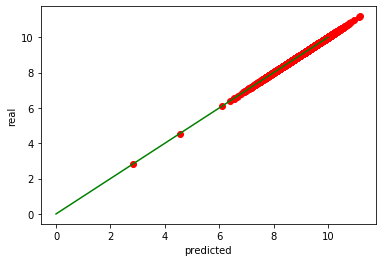

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [46]:
# Create linear regression object
linreg = LinearRegression(fit_intercept=True)

# Train the model using the training sets
linreg.fit(X_train,y_train)

#print ("Linear model: ", pretty_print_linear(linreg.coef_, names, sort = True))

# Predict the values using the model
y_lin_predict = linreg.predict(X_test)

# Print the root mean square error 
print ("Root Mean Square Error: {}".format(root_mean_square_error(y_lin_predict,y_test)))
print("R^2:"+str(round(r2_score(y_test, y_lin_predict),4)))
plot_real_vs_predicted(y_test,y_lin_predict)

In [47]:
generate_regression_values(linreg, X_test, y_test)

     Coefficients  Standard Errors      t values  Probabilites
0          9.1123              0.0  2.256367e+17         0.000
1          0.6972              0.0  6.059238e+15         0.000
2          0.0000              0.0  6.700000e-02         0.946
3         -0.0000              NaN           NaN           NaN
4         -0.0000              NaN           NaN           NaN
..            ...              ...           ...           ...
96        -0.0000              0.0 -1.220000e-01         0.903
97        -0.0000              0.0 -1.907000e+00         0.057
98        -0.0000              0.0 -9.600000e-02         0.924
99         0.0000              0.0  1.820000e-01         0.856
100       -0.0000              0.0 -5.670000e-01         0.571

[101 rows x 4 columns]


### Lasso Regression:

Root Mean Square Error:  0.30026514261613674
R^2:0.8145


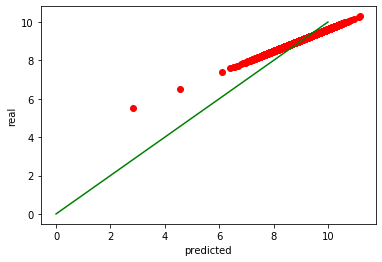

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [48]:
# create lasso regression object
lasso = Lasso(fit_intercept=True, alpha=.3)

# train the model using the training sets
lasso.fit(X_train, y_train) 

# print ("Lasso model: ", pretty_print_linear(lasso.coef_, names, sort = True))

# predict the values using the model
y_lasso_predict = lasso.predict(X_test)

# print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(y_lasso_predict,y_test))
print("R^2:"+str(round(r2_score(y_test, y_lasso_predict),4)))
plot_real_vs_predicted(y_test, y_lasso_predict)

In [49]:
generate_regression_values(lasso, X_test, y_test)

     Coefficients  Standard Errors  t values  Probabilites
0          9.1161            0.005  1872.918           0.0
1          0.3971            0.014    28.635           0.0
2          0.0000         3356.243     0.000           1.0
3          0.0000              NaN       NaN           NaN
4          0.0000              NaN       NaN           NaN
..            ...              ...       ...           ...
96         0.0000            0.041     0.000           1.0
97         0.0000            0.008     0.000           1.0
98         0.0000            0.031     0.000           1.0
99         0.0000            0.051     0.000           1.0
100        0.0000            0.010     0.000           1.0

[101 rows x 4 columns]


### Ridge Regression

Root Mean Square Error:  7.076503943774454e-05
R^2:1.0


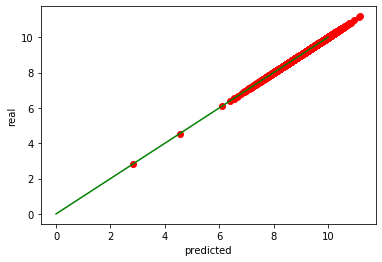

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [50]:
ridge = Ridge(fit_intercept=True, alpha=.3)
              
# train the model using the training sets
ridge.fit(X_train, y_train) 

# print ("Ridge model: ", pretty_print_linear(ridge.coef_, names, sort = True))

# predict the values using the model
y_ridge_predict = ridge.predict(X_test)

# print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(y_ridge_predict,y_test))
print("R^2:"+str(round(r2_score(y_test, y_ridge_predict),4)))
plot_real_vs_predicted(y_test,y_ridge_predict)

In [51]:
generate_regression_values(ridge, X_test, y_test)

     Coefficients  Standard Errors     t values  Probabilites
0          9.1123            0.000  7943763.084         0.000
1          0.6970            0.000   213265.618         0.000
2          0.0000            0.791        0.000         1.000
3          0.0000              NaN          NaN           NaN
4          0.0000              NaN          NaN           NaN
..            ...              ...          ...           ...
96        -0.0000            0.000       -1.129         0.259
97         0.0000            0.000        2.020         0.043
98        -0.0000            0.000       -0.287         0.774
99         0.0000            0.000        1.981         0.048
100        0.0000            0.000        0.872         0.383

[101 rows x 4 columns]


### Regression via Elastic Net

Root Mean Square Error:  0.22041047083196486
R^2:0.9


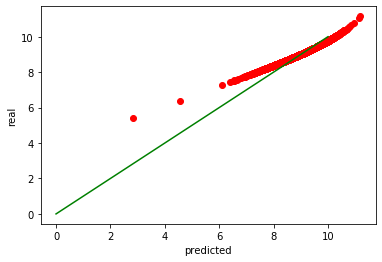

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [52]:
elnet = ElasticNet(fit_intercept=True, alpha=.3)
              
# train the model using the training sets
elnet.fit(X_train, y_train) 

# print ("Elastic Net model: ", pretty_print_linear(elnet.coef_, names, sort = True))

# predict the values using the model
y_elnet_predict = elnet.predict(X_test)

# print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(y_elnet_predict,y_test))
print("R^2:"+str(round(r2_score(y_test, y_elnet_predict),4)))
plot_real_vs_predicted(y_test,y_elnet_predict)

### Regression via Stochastic Gradient Descent

Root Mean Square Error:  0.5949933472082792
R^2:0.2715


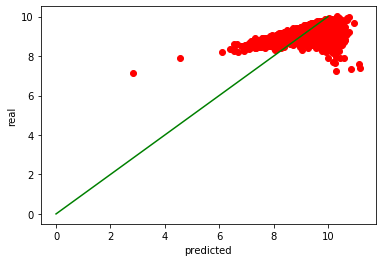

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [53]:
sgdreg = SGDRegressor(fit_intercept=True, alpha=.3)

# train the model using the training sets
sgdreg.fit(X_train, y_train) 

# print ("Stochastic Gradient Descent model: ", pretty_print_linear(sgdreg.coef_, names, sort = True))

# predict the values using the model
y_sgdreg_predict = sgdreg.predict(X_test)

# print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(y_sgdreg_predict,y_test))
print("R^2:"+str(round(r2_score(y_test, y_sgdreg_predict),4)))
plot_real_vs_predicted(y_test,y_sgdreg_predict)

### Lets try Neural Network 

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())-1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________


In [65]:
EPOCHS = 1000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.9264,  mean_absolute_error:1.3021,  mean_squared_error:4.9264,  val_loss:0.5509,  val_mean_absolute_error:0.5537,  val_mean_squared_error:0.5509,  
....................................................................................................
Epoch: 100, loss:0.0211,  mean_absolute_error:0.1139,  mean_squared_error:0.0211,  val_loss:0.0732,  val_mean_absolute_error:0.2156,  val_mean_squared_error:0.0732,  
....................................................................................................
Epoch: 200, loss:0.0109,  mean_absolute_error:0.0792,  mean_squared_error:0.0109,  val_loss:0.0145,  val_mean_absolute_error:0.0973,  val_mean_squared_error:0.0145,  
....................................................................................................
Epoch: 300, loss:0.0073,  mean_absolute_error:0.0652,  mean_squared_error:0.0073,  val_loss:0.0030,  val_mean_absolute_error:0.0412,  val_mean_squared_error:0.0030,  
..............................

In [66]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.001863,0.031682,0.001863,0.002552,0.040785,0.002552,995
996,0.001865,0.032703,0.001865,0.001906,0.035370,0.001906,996
997,0.001784,0.031748,0.001784,0.001173,0.026501,0.001173,997
998,0.001874,0.032757,0.001874,0.000951,0.023383,0.000951,998
999,0.001658,0.030822,0.001658,0.007998,0.066188,0.007998,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

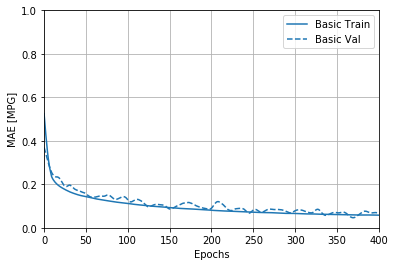

In [79]:
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 1])
plt.xlim([0, 400])
plt.ylabel('MAE [MPG]')